# 18기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.
데이터셋 출처 :  https://www.kaggle.com/datasets/shenba/time-series-datasets

### Box-Jenkins 방법론
대략적 흐름 예시를 확인하고 싶다면 첨부한 '시계열자료_참고자료.pdf'를 읽어주세요.

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ToBig's/week5/Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
df = df.set_index("DATE")
df.head()

,IPG2211A2N
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151


## 시계열 데이터 식별

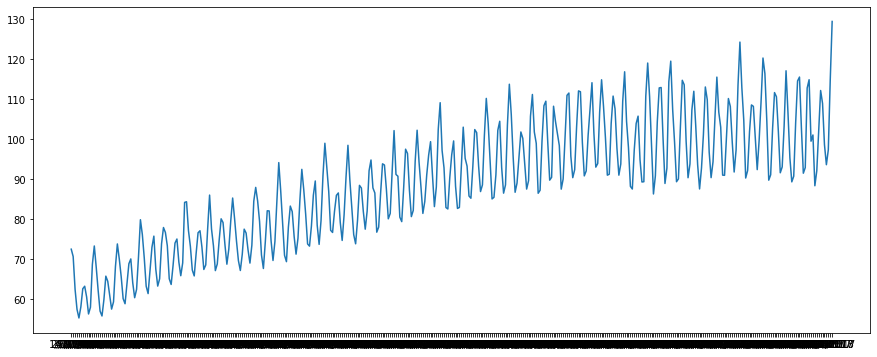

In [ ]:
# 시계열도 그려보기
plt.figure(figsize=(15,6))
plt.plot(df.index, df["IPG2211A2N"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show()

시계열도를 그려 확인해보니 상승하는 추세를 보이며, 계절성의 패턴을 가지고 있음. 따라서 비정상 시계열이라고 판단할 수 있다.

In [ ]:
df

,IPG2211A2N
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151
...,...
9/1/2017,98.6154
10/1/2017,93.6137
11/1/2017,97.3359


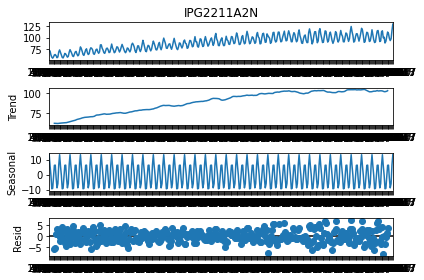

In [ ]:
#분해법을 통해 변동성분을 확인해본다.
result = seasonal_decompose(df["IPG2211A2N"], model = 'additive', period=12) #가법모델을 이용해서
result.plot()
plt.show()

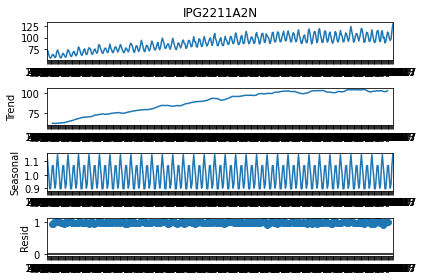

In [ ]:
#분해법을 통해 변동성분을 확인해본다.
result = seasonal_decompose(df["IPG2211A2N"], model = 'multiplicative', period=12) #승법모델을 이용해서
result.plot()
plt.show()

분해법을 이용해 확인해본 결과 확실히 trend와 계절성이 존재한다는 것을 알 수 있다.

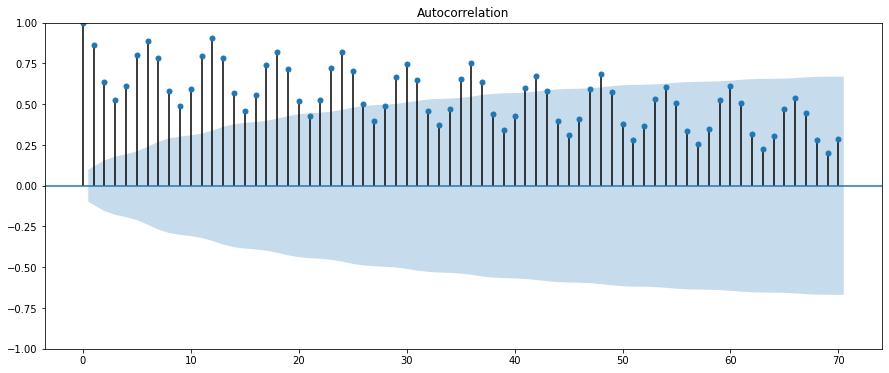

In [ ]:
#ACF 그려보기
fig = plt.figure(figsize=(15,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
plot_acf(df["IPG2211A2N"], lags=70, ax=ax)
plt.show()

ACF를 그려본 결과 특정 패턴이 존재한다. 곡선의 형태를 가지며 점차 줄어드는 것을 관찰할 수 있다. => 비정상 시계열

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


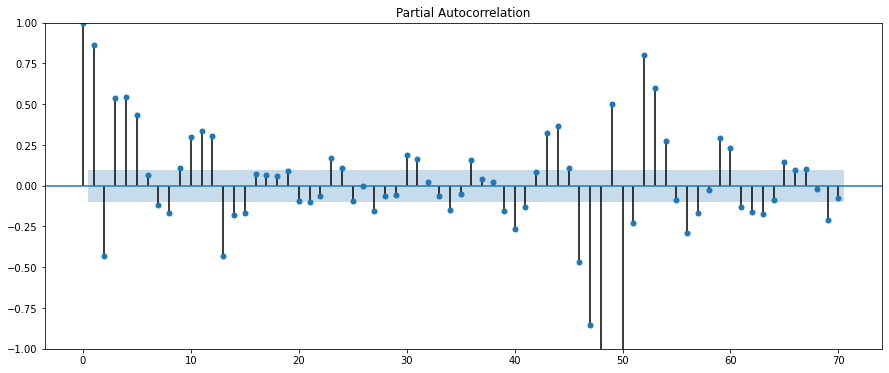

In [ ]:
#PACF 그려보기
fig = plt.figure(figsize=(15,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
plot_pacf(df["IPG2211A2N"], lags=70, ax=ax)
plt.show()

PCAF로는 정확한 의미를 파악하기 어렵다. 그러나 lag 6이후로 어느정도 점선 아래로 내려가므로 일단 AR(6)을 잠정모형으로 추측해볼 수 있다.

시계열도와 ACF 패턴 파악을 통해 주어진 데이터는 비정상 시계열이라는 판단. ARIMA 모형을 이용하기로 한다.

## 어떤 모형을 적용할 것인가?

비정상 시계열이므로 차분을 통해 시계열을 정상화 시켜줄 수 있다.

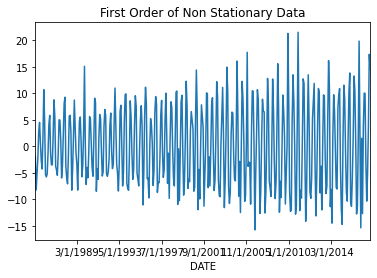

In [ ]:
#1차 차분을 진행한다.
df['1st'] = df["IPG2211A2N"].diff() # 판다스의 diff 메소드를 이용
df['1st'].plot(title='First Order of Non Stationary Data').autoscale(axis='x', tight=True)

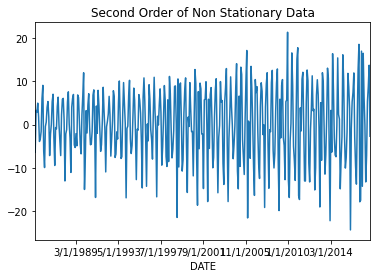

In [ ]:
#어느 정도는 추세가 사라졌으나 여전히 추세가 보이므로 한번 더 차분을 진행해본다.
#2차 차분 진행
df['2nd'] = df['1st'].diff() # 판다스의 diff 메소드를 이용
df['2nd'].plot(title='Second Order of Non Stationary Data').autoscale(axis='x', tight=True)

어느정도 정상 시계열에 가까워졌는지 확인하기 위해 adf 검정을 이용해본다.

In [ ]:
#ADF 검정을 위한 함수 작성

from statsmodels.tsa.stattools import adfuller

def adf(df):
  result = adfuller(df)
  print('ADF statistics :', result[0])
  print('p-vlaue :', result[1])
  print('Critical values:')
  for key, value in result[4].items():
    print('\t%s : %.3f' %(key, value))

In [ ]:
df

,IPG2211A2N,1st,2nd
DATE,,,
1/1/1985,72.5052,NaN,NaN
2/1/1985,70.6720,-1.8332,NaN
3/1/1985,62.4502,-8.2218,-6.3886
4/1/1985,57.4714,-4.9788,3.2430
5/1/1985,55.3151,-2.1563,2.8225
...,...,...,...
9/1/2017,98.6154,-10.3158,-7.0932
10/1/2017,93.6137,-5.0017,5.3141
11/1/2017,97.3359,3.7222,8.7239


nan값이 존재하기 때문에 adf 계산에 사용할 시리즈를 다시 만들어준다.

In [ ]:
second = df['2nd']
second = second.dropna()
second

DATE
3/1/1985     -6.3886
4/1/1985      3.2430
5/1/1985      2.8225
6/1/1985      4.9316
7/1/1985      1.7545
              ...   
9/1/2017     -7.0932
10/1/2017     5.3141
11/1/2017     8.7239
12/1/2017    13.6631
1/1/2018     -2.7017
Name: 2nd, Length: 395, dtype: float64

In [ ]:
adf(second)

ADF statistics : -9.863042323279306
p-vlaue : 4.1836937479977153e-17
Critical values:
	1% : -3.448
	5% : -2.869
	10% : -2.571


유의수준을 0.05로 잡았을 때 유의수준보다 p-value가 더 작으므로 귀무가설을 기각할 수 있다. 즉, 정상 시계열 범주에 들어왔다고 할 수 있다.

In [ ]:
adf(df['IPG2211A2N'])

ADF statistics : -2.2569903500472366
p-vlaue : 0.18621469116587053
Critical values:
	1% : -3.448
	5% : -2.869
	10% : -2.571


In [ ]:
first = df['1st']
first = first.dropna()

adf(first)

ADF statistics : -7.104890882267309
p-vlaue : 4.0777865655394705e-10
Critical values:
	1% : -3.448
	5% : -2.869
	10% : -2.571


추가적으로 원본 데이터와 1차 차분 데이터의 adf 검정을 진행해보았는데, 1차 차분 데이터부터 p-value가 0.05보다 작으므로 1차 차분으로도 충분하다고 판단 가능하다.

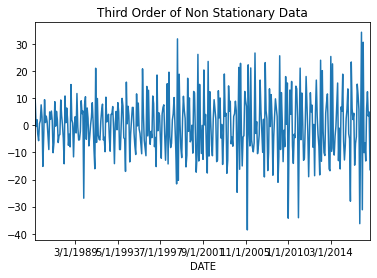

In [ ]:
#더 이상 진행하면 과대 차분될 수 있지만, 확인을 위해 한번 더 진행해본다.
#3차 차분 진행
df['3rd'] = df['2nd'].diff() # 판다스의 diff 메소드를 이용
df['3rd'].plot(title='Third Order of Non Stationary Data').autoscale(axis='x', tight=True)

차분을 진행할수록 실제로 점차 화이트노이즈의 개형을 띠는 것을 확인할 수 있다. 그러나 과대차분 위험이 있으므로 1차 차분에서 멈추기로 한다.

## ARIMA 예측

In [ ]:
#train, test 데이터 나누기

train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

ACF를 통해 AR(6) 모형을, 차분을 통해 1차 차분을 적용하는 것을 잠정모형으로 삼았다. 따라서 이를 이용해 ARIMA 예측을 진행해보자

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train_data['IPG2211A2N'], order = (6,1,3), seasonal_order = (4,1,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimizati

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         IPG2211A2N   No. Observations:                  385
Model:             SARIMAX(6, 1, 3)x(4, 1, 3, 12)   Log Likelihood                -833.413
Date:                            Mon, 22 Aug 2022   AIC                           1700.826
Time:                                    20:00:18   BIC                           1767.447
Sample:                                01-01-1985   HQIC                          1727.283
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2688      2.024     -0.133      0.894      -4.235       3.698
ar.L2          0.4326      0.789      0.548      0.583      -1.114       1.979
ar.L3         -0.0564      0.818     -0.069      0.945      -1.659       1.547
ar.L4          0.0295      0.086      0.343      0.732      -0.139       0.198
ar.L5         -0.0804      0.096     -0.838      0.402      -0.269       0.108
ar.L6          0.0435      0.174      0.250      0.802      -0.297       0.384
ma.L1         -0.1444      2.033     -0.071      0.943      -4.129       3.840
ma.L2         -0.8374      0.095     -8.774      0.000      -1.024      -0.650
ma.L3          0.0801      1.743      0.046      0.963      -3.336       3.496
ar.S.L12       0.2826      1.807      0.156      0.876      -3.259       3.825
ar.S.L24       0.0416      1.405      0.030      0.976      -2.712       2.795
ar.S.L36      -0.0731      0.495     -0.148      0.883      -1.044       0.897
ar.S.L48      -0.0092      0.156     -0.059      0.953      -0.315       0.297
ma.S.L12      -1.0216      1.808     -0.565      0.572      -4.566       2.523
ma.S.L24      -0.0283      2.727     -0.010      0.992      -5.372       5.316
ma.S.L36       0.2804      1.174      0.239      0.811      -2.021       2.582
sigma2         4.9632      0.336     14.786      0.000       4.305       5.621
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.99
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2017-02-01    105.777014
2017-03-01     98.302676
2017-04-01     89.105084
2017-05-01     90.969349
2017-06-01    103.323663
2017-07-01    112.395598
2017-08-01    112.000278
2017-09-01     99.956040
2017-10-01     91.514162
2017-11-01     95.157505
2017-12-01    111.314395
2018-01-01    118.179087
Freq: MS, Name: ARIMA Predictions, dtype: float64

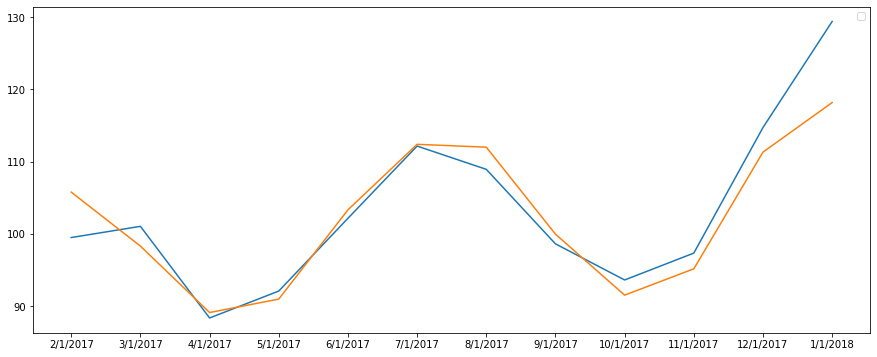

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test_data.index, test_data['IPG2211A2N'])
plt.plot(test_data.index, arima_pred)
plt.legend()

마지막 2017년 12월 부근부터는 크게 어긋나지만 그 외에는 잘 예측하는 것을 볼 수 있다.

In [ ]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test_data['IPG2211A2N'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['IPG2211A2N'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 17.353145436767278
RMSE Error: 4.165710676075245
Mean: 88.84721763224182


### auto-arima 이용해보기

In [ ]:
train = train_data['IPG2211A2N']

In [ ]:
from statsmodels.compat.numpy import NP_LT_123
import pmdarima as pm

model = pm.auto_arima(y = train     # 데이터
                      , d = 1      # 차분 차수   
                      , seasonal = True # 계절성
                      , m = 12
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2657.357, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2308.651, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2655.436, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2531.251, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1840.978, Time=2.21 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1957.997, Time=0.70 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1841.393, Time=4.90 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1842.833, Time=5.76 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2229.577, Time=1.75 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1916.667, Time=2.21 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1866.130, Time=1.23 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept

auto-arima를 통해서 알아낸 모델은

>  ARIMA(1,1,2)(2,0,2)[12]
이때 AIC = 1777 정도로 추정했던 모델보다 좋지 않은 값이다.



In [ ]:
arima_model = SARIMAX(train_data['IPG2211A2N'], order = (1,1,2), seasonal_order = (2,0,2,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed t

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         IPG2211A2N   No. Observations:                  385
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -880.512
Date:                            Mon, 22 Aug 2022   AIC                           1777.024
Time:                                    19:54:21   BIC                           1808.629
Sample:                                01-01-1985   HQIC                          1789.560
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3553      0.101      3.534      0.000       0.158       0.552
ma.L1         -0.7323      0.101     -7.241      0.000      -0.931      -0.534
ma.L2         -0.2041      0.089     -2.301      0.021      -0.378      -0.030
ar.S.L12       0.5200      0.273      1.908      0.056      -0.014       1.054
ar.S.L24       0.4738      0.271      1.752      0.080      -0.056       1.004
ma.S.L12      -0.1761      0.265     -0.664      0.507      -0.696       0.344
ma.S.L24      -0.4690      0.181     -2.590      0.010      -0.824      -0.114
sigma2         5.2527      0.358     14.661      0.000       4.551       5.955
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.55
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.66   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

계절성이므로 seasonal_order의 두번째 파라미터만 1으로 바꿔보자.

In [ ]:
arima_model = SARIMAX(train_data['IPG2211A2N'], order = (1,1,2), seasonal_order = (2,1,2,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         IPG2211A2N   No. Observations:                  385
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -838.124
Date:                            Mon, 22 Aug 2022   AIC                           1692.247
Time:                                    20:17:53   BIC                           1723.599
Sample:                                01-01-1985   HQIC                          1704.698
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4171      0.106      3.922      0.000       0.209       0.626
ma.L1         -0.8447      0.111     -7.583      0.000      -1.063      -0.626
ma.L2         -0.0940      0.097     -0.968      0.333      -0.284       0.096
ar.S.L12       0.5742      0.188      3.053      0.002       0.206       0.943
ar.S.L24      -0.2753      0.062     -4.447      0.000      -0.397      -0.154
ma.S.L12      -1.2843      0.186     -6.912      0.000      -1.648      -0.920
ma.S.L24       0.4889      0.151      3.234      0.001       0.193       0.785
sigma2         5.1001      0.338     15.080      0.000       4.437       5.763
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.91
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.54   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC가 좋아진 것을 확인할 수 있다.

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2017-02-01    106.116595
2017-03-01     98.369083
2017-04-01     89.482237
2017-05-01     91.575311
2017-06-01    102.939473
2017-07-01    112.834040
2017-08-01    112.032968
2017-09-01    100.586692
2017-10-01     91.660171
2017-11-01     95.524200
2017-12-01    111.209741
2018-01-01    118.388109
Freq: MS, Name: ARIMA Predictions, dtype: float64

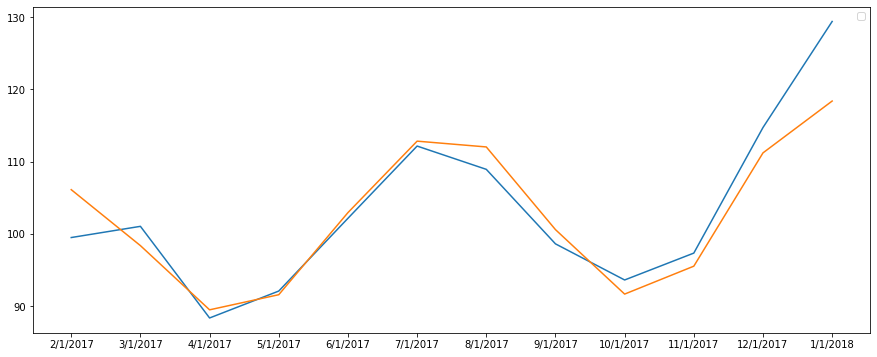

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(test_data.index, test_data['IPG2211A2N'])
plt.plot(test_data.index, arima_pred)
plt.legend()

In [ ]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test_data['IPG2211A2N'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['IPG2211A2N'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 17.32972964533775
RMSE Error: 4.162899187505956
Mean: 88.84721763224182


추정 모델에 비해 auto-arima로 파라미터를 조정했을 때 mse가 작다. 그러나 이는 계절변동의 2번째 파라미터를 1로 바꿔주었을 때의 결과다. 따라서 auto-arima를 이용하되, 시계열 데이터의 추세를 보고 다시 파라미터를 조정하는 것 역시 중요하다는 것을 알 수 있었다,

## Prophet 이용해보기

In [ ]:
df_pr = pd.read_csv("/content/drive/MyDrive/ToBig's/week5/Electric_Production.csv")

In [ ]:
df_pr

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [ ]:
df_pr.columns = ['ds','y']

In [ ]:
train_data_pr = df_pr.iloc[:len(df)-12]
test_data_pr = df_pr.iloc[len(df)-12:]

In [ ]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638909 sha256=05055193faf84e77c9f51a7d704424dca3a484631f711c4a94bf5e0668da0a1b
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


In [ ]:
from fbprophet import Prophet

In [ ]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
392,2017-09-01,103.671566,97.522743,104.543487,103.656197,103.690550,-2.738816,-2.738816,-2.738816,-2.738816,-2.738816,-2.738816,0.0,0.0,0.0,100.932750
393,2017-10-01,103.694993,91.129044,98.370763,103.672944,103.720253,-9.101383,-9.101383,-9.101383,-9.101383,-9.101383,-9.101383,0.0,0.0,0.0,94.593609
394,2017-11-01,103.719201,94.089969,101.124268,103.690607,103.750872,-6.258155,-6.258155,-6.258155,-6.258155,-6.258155,-6.258155,0.0,0.0,0.0,97.461046
395,2017-12-01,103.742627,106.941556,113.819489,103.707403,103.781668,6.462270,6.462270,6.462270,6.462270,6.462270,6.462270,0.0,0.0,0.0,110.204897
396,2018-01-01,103.766835,113.026001,119.971651,103.725918,103.815149,12.774363,12.774363,12.774363,12.774363,12.774363,12.774363,0.0,0.0,0.0,116.541198


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred

,Pred
Date,
2017-02-01,108.899964
2017-03-01,102.734616
2017-04-01,94.296206
2017-05-01,94.418738
2017-06-01,102.226387
2017-07-01,109.425534
2017-08-01,109.520097
2017-09-01,100.932750
2017-10-01,94.593609


In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


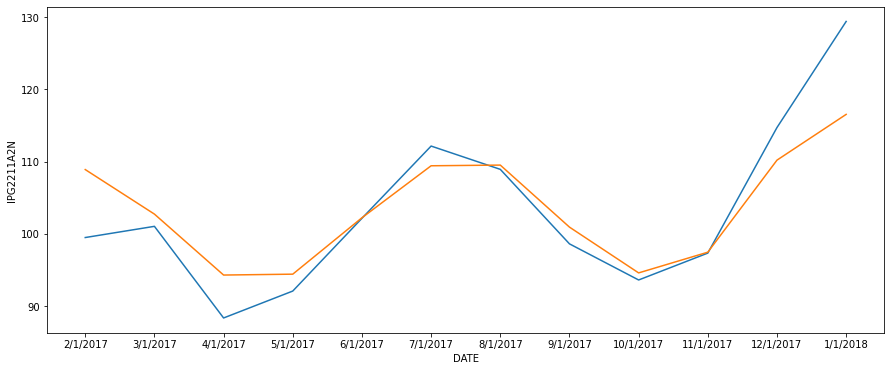

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,6))
ax = sns.lineplot(x= test_data.index, y=test_data["IPG2211A2N"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"])

In [ ]:
prophet_rmse_error = rmse(test_data['IPG2211A2N'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['IPG2211A2N'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 27.684875091367246
RMSE Error: 5.261641862704763
Mean: 88.84721763224182


그래프 상으로 봤을 때나 mse를 구해봤을 때, arima 보다 정확도가 떨어지는것을 볼 수 있다. 하지만 매우 빠르고 간편하게 구해낼 수 있었다.

In [ ]:
rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

In [ ]:
errors

,Models,RMSE Errors,MSE Errors
0,ARIMA,4.162899,17.329730
1,Prophet,5.261642,27.684875


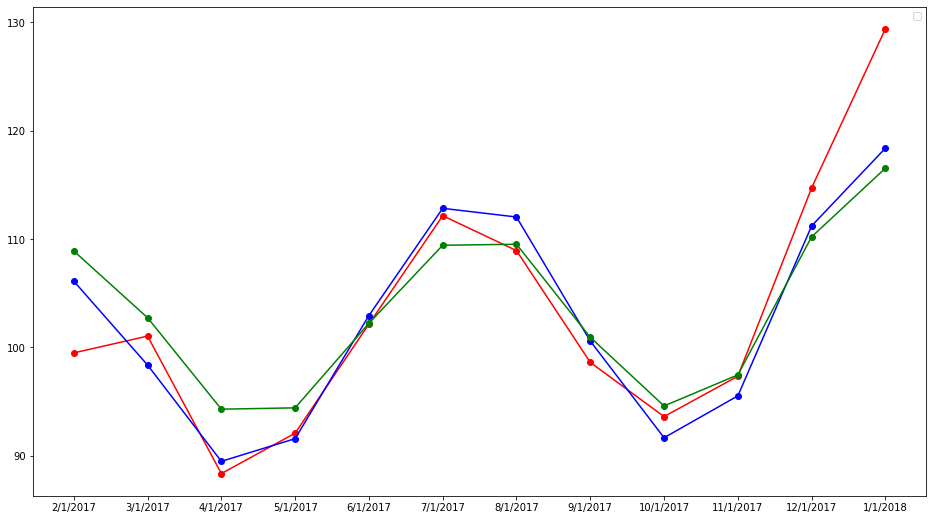

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data['IPG2211A2N'], color = "red", linestyle="-")
plt.plot_date(test_data.index, arima_pred, color = "blue", linestyle="-")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], color = "green", linestyle="-")
plt.legend()
plt.show()

확실히 파란색으로 그려진 arima 예측이 실제값인 빨간 그래프와 유사한 것을 볼 수 있다.